In [1]:
#!pip install transformers
#!pip install datasets
#!pip install fastai
#!pip install ohmeow-blurr

In [2]:
#!pip install seqeval

# Skript3: Model Finetuning für Text-Klassifizierung mit germaneval2019 Task2 -Subtask2 mit Fast-AI

Dieses Notebook beschreibt das Training eines Text-Klassifizierungsmodells für den Datensatz GermEval 2019 Task2 -Subtask2.
Es wird ein BERT - Modell mit der Fast-AI und der Blurr Bibliothek trainiert. Das Training erfolgt nach dem gleichen Split wie es der Shared Task 2019 vorgab.

In [3]:
# Importieren der Hugging Face Datesets Bibliothek
import datasets
from fastai.text.all import *
from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Parameter für die Scriptsteuerung:
# die Task für die das Modell trainiert werden soll
task = "task2"
# das zu verwendende pretrained Transformer Modell
model_checkpoint = "deepset/gbert-base"
# die Trainingsbatchsize
batch_size = 4

In [5]:
# Festlegen weiterer Scriptparameter anhand der gewählten Task:
if task == "task1":
    num_labels = 2
    y_col = "task1_label"
else:
    num_labels = 4
    y_col = "task2_label"

## Herunterladen und Bereitstellen der Transformers Komponenten.
Dafür wird lediglich der gewünschte model_checkpoint an die Methode `BLURR_MODEL_HELPER.get_hf_objects` übergeben. Diese beschafft das entsprechende Model und die zugehörigen Daten wie den Tokenizer für die gewählte Task:

In [6]:
hf_task = HF_TASKS_AUTO.SequenceClassification
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(model_checkpoint, task=hf_task,config_kwargs={'num_labels': num_labels})

## Preprocessing des Datasets

In [7]:
import pandas as pd

Zunächst werden  alle Trainingsdaten aus dem GermEval2019 Dataset zu einem Pandas Dataframe zusammengefügt:

In [8]:
data1=pd.read_csv("../datasets/germeval2019/train_valid/germeval2018.test_.txt",sep='\t', header=None,quoting=3)
data2=pd.read_csv("../datasets/germeval2019/train_valid/germeval2018.training.txt",sep='\t', header=None,quoting=3)
data3=pd.read_csv("../datasets/germeval2019/train_valid/germeval2019.training_subtask1_2_korrigiert.txt",sep='\t',quoting=3, header=None)
data_all = data1.append([data2,data3])
data_all.columns = ["text","task1_label","task2_label"]
data_all.head()

,text,task1_label,task2_label
0,"Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist ☺",OTHER,OTHER
1,"@Tom174_ @davidbest95 Meine Reaktion; |LBR| Nicht jeder Moslem ist ein Terrorist. Aber jeder Moslem glaubt an Überlieferungen, die Gewalt und Terror begünstigen.",OTHER,OTHER
2,"#Merkel rollt dem Emir von #Katar, der islamistischen Terror unterstützt, den roten Teppich aus.Wir brauchen einen sofortigen #Waffenstopp!",OTHER,OTHER
3,„Merle ist kein junges unschuldiges Mädchen“ Kch....... 😱 #tatort,OTHER,OTHER
4,@umweltundaktiv Asylantenflut bringt eben nur negatives für Deutschland. Drum Asylanenstop und Rückführung der Mehrzahl.,OFFENSE,ABUSE


Verarbeiten des Testdatensatzes in einen Dataframe:

In [9]:
data_test = pd.read_csv("../datasets/germeval2019/test/germeval2019GoldLabelsSubtask1_2.txt",delimiter="\t",quoting=3, header=None)
data_test.columns = ["text","task1_label","task2_label"]
# Fügt eine Spalte is_valid ein die eine Zeile makiert als Teil des Validationsets
data_test['is_valid']=True
dummy_row ={'text':'dummy','task1_label':'OTHER','task2_label':"OTHER",'is_valid':False}
# Einfügen der Dummyzeile, sodass im Anschluss im DataBlock der ColSplitter verwendet werden kann und das Testset komplett ist
data_test = data_test.append(dummy_row,ignore_index=True)
data_test.tail()

,text,task1_label,task2_label,is_valid
3027,"Um es klar zu stellen: Ich will hier kein White-Washing betreiben (hätte er die Unterstützung der Kurden gegen die Entente-Mächte wie versprochen belohnt, wäre etliches Leid in der Folge erspart geblieben). Just my 2 cents.",OTHER,OTHER,True
3028,"Und dann habe ich da noch die McArthur-Briefe im Sinn. Alles in allem ist mein Eindruck der, dass er damals moderner war als heutige Kemalisten.",OTHER,OTHER,True
3029,al sehen wer der Ersatzmann wird. Hier könnte man ggf. die aktuelle Richtung des VS korrigieren. Erfahrungsbedingt habe ich da etliche Zweifel.,OTHER,OTHER,True
3030,@JKasek Oder die Bäume. Bin mal in 'nem Wald spazieren gegangen und so'n Baum griff mich doch glatt mit 'nem Zapfen an. Bin noch mal mit meinem Leben davon gekommen.,OTHER,OTHER,True
3031,dummy,OTHER,OTHER,False


## Erstellen der DataLoader via DataBlock API

Um die Trainingsdaten in das Modell zu füttern, wird in Fast-AI ein DataLoader benötigt. Dieser kann mit der DataBlock API erstellt werden. Hierfür übergibt man dem Konstruktur die entsprechenden Blöcke und Informationen darüber, wie die x und y Variable aus den Datensätzen zu ermitteln sind.\
Der `HF_TextBlock` wird verwendet, weil die x-Variable roher Text ist. Der Block kümmert sich um die Anreicherung und Tokenisierung der Eingabedaten des Modells. Dafür wird automatisch der zugehörige Tokenizer der Transformerarchitektur verwendet.\
Der zweite Block bestimmt die Natur der y-Variable. Da es sich hier um ein Klassifizierungsproblem handelt, wird der `CategoryBlock` verwendet. Dieser wandelt die Inhalte der Labelspalte automatisch in entsprechende Kategorieencodings um.\
Durch die Parameter `get_x` und `get_y` kann dem `DataBlock` mitgeteilt werden, wie er die x- und y-Variable beschaffen soll. In diesem Fall wird dies mit einem `ColReader` durchgeführt, welcher die entsprechenden Werte aus der Spalte `text` und der Labelspalte extrahiert.\
Der `splitter` Parameter bestimmt, wie der Datensatz aufgeteilt werden soll. Der gewählte Splitter ist der `RandomSplitter`. Dieser ordent die Daten zufällig dem Trainings und dem Validierungsset zu. Die gewählte Aufteilung ist 80 % Trainingsset und 20 % Validierungsset.


In [10]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())
dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader(y_col), splitter=RandomSplitter(valid_pct=0.2, seed=42))

Mithilfe der `summary` Methode kann man einen Problelauf des DataBlock starten. Die Ausgabe gibt Auskünfte darüber, was während der Verabeitung der Daten passiert und ob es zu Fehlern kommt. 

In [11]:
dblock.summary(data_all)

Setting-up type transforms pipelines
0                                          Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist ☺   
1     @Tom174_ @davidbest95 Meine Reaktion; |LBR| Nicht jeder Moslem ist ein Terrorist. Aber jeder Moslem glaubt an Überlieferungen, die Gewalt und Terror begünstigen.   
2                           #Merkel rollt dem Emir von #Katar, der islamistischen Terror unterstützt, den roten Teppich aus.Wir brauchen einen sofortigen #Waffenstopp!   
3                                                                                                     „Merle ist kein junges unschuldiges Mädchen“ Kch....... 😱 #tatort   
4                                              @umweltundaktiv Asylantenflut bringt eben nur negatives für Deutschland. Drum Asylanenstop und Rückführung der Mehrzahl.   
...                                                                                                         

Im Anschluss kann der `DataLoader` für die Trainingsdaten erzeugt werden. Die verwendete Batch Size liegt bei 4 aufgrund der begrenzten Speicherkapazitäten der verwendeten GPU.

In [12]:
dls =  dblock.dataloaders(source=data_all,bs=batch_size)

Wie mit jedem `DataLoader` in Fast-AI kann auch hier ein Beispiel Batch visualisiert werden. Dies wird mit der Methode `show_batch` gestartet.

In [13]:
dls.show_batch(dataloaders=dls)

,text,category
0,"@ _ Migraene _ @ Grace30714933 @ RalfTHeuer @ Venum27004632 @ chris _ 98763 @ CoYoSilver @ ph _ phanuel @ ChisNoria @ assassina36 @ wellejena @ Bibby182 @ bine1007 @ Iamcovar @ AufgewachteWelt @ EngelGert @ Lukas64F @ Ron1872 @ Ungebeten1 @ PTroll3 @ _ Apuleius @ LouisPeterle @ machata9 @ Ich _ hake _ nach @ n59 _ puppche @ KoyamaMichi @ Cherylli18 @ BoteDesUnrechts @ ASiegwart @ freitweeter @ OdmantSuperstar @ Lanyihunter1 @ smuelle26677552 @ MaXanonymous @ Johannes135 @ FredKrger2 @ Connybub @ heidi1274 @ pseudros @ Strandvogt3 @ MadameSchwarzi @ Hausfrau4ever @ Robert19594 @ Invictu53409591 @ Vigilant _ _ A @ estathor @ Metalwilli @ willplaat @ 2018Wahrheit @ Kabra66 Ist über den Punkt. | LBR | Wer als weißer westlicher Mann jemals wieder einer westlich weißen Frau vertraut... | LBR | Das wird nicht wieder weggehen, sich tief in die Seele einbrennen. | LBR | Wer will schon solche illoyalen Frauen haben? | LBR | "" Vergewaltigungsmaterial ""? | LBR | So sehen sie die Horden.",ABUSE
1,@ ErdoSultan @ _ Migraene _ @ Venum27004632 @ RobertaFlint2 @ CoYoSilver @ n59 _ puppche @ assassina36 @ MSrebre @ Bibby182 @ ph _ phanuel @ ChisNoria @ wellejena @ bine1007 @ Iamcovar @ AufgewachteWelt @ EngelGert @ Lukas64F @ Ron1872 @ Ungebeten1 @ PTroll3 @ _ Apuleius @ chris _ 98763 @ LouisPeterle @ machata9 @ Ich _ hake _ nach @ KoyamaMichi @ Cherylli18 @ BoteDesUnrechts @ ASiegwart @ RalfTHeuer @ freitweeter @ OdmantSuperstar @ Lanyihunter1 @ smuelle26677552 @ MaXanonymous @ Johannes135 @ FredKrger2 @ Connybub @ heidi1274 @ pseudros @ Strandvogt3 @ MadameSchwarzi @ Hausfrau4ever @ Robert19594 @ Invictu53409591 @ Vigilant _ _ A @ estathor @ Metalwilli @ willplaat Wie wär's wenn diese Trollerei hier jetzt aufhört?,OTHER
2,"@ mastermikeg @ _ macmike @ Steffmann45 @ troll _ putin @ petpanther0 @ machtjanix23 @ Norbinator2403 @ ennof _ @ AthinaMala @ NancyPeggyMandy @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ ellibisathide @ MD _ Franz Wäre Belastungsmaterial gegen die NSU drin, wären die Akten offen.",OTHER
3,"@ info2099 @ SnoopysBrain @ 1Netzreport @ peppermind @ mittelfinger Um mich hier einzuklinken, kurze Info an euch, verzettelt euch nicht in diesen ( Nazidiskussionen ) den das ist von der BRD Mafia gewollt, „ teile und herrsche “ ist deren System fallt nicht darauf herein, Einigkeit hassen Sie, deshalb vereinigt euch alle",OTHER


Um das Modell im Anschluss des Trainings mit den ungesehenen Testdaten prüfen zu können, müssen diese ebenfalls durch einen `DataLoader` zur Verfügung gestellt werden. Dafür wird ein weiterer `DataBlock` erzeugt, der als Blaupause für den `DataLoader` dienen wird. Der folgende `DataBlock` unterscheidet sich nur im gewählten `splitter` vom vorherigen. Der `ColSplitter` ermöglicht es, die Datensätze eines DataFrames automatisch nach dem Inhalt der Spalte `is_valid` aufzuteilen. Dabei wird jeder Datensatz dem Validierungsset zugeordnet, der den Wert `True` in dieser Spalte enthält.

In [14]:
blocks_test = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())
dblock_test = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader(y_col), splitter=ColSplitter())

In [15]:
dls_test = dblock_test.dataloaders(source=data_test,bs=batch_size)

Ausgabe eines Beispielbatches aus dem Testset:

In [16]:
dls_test.valid.show_batch(dataloaders=dls_test)

,text,category
0,"@ pozelt @ BR24 Des is koa Lebakassemme ned. Moch dei Aung auf, des is a Lebakaskrapfn! | LBR | Ja, spinn i denn? BLASPHEMIE! < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 >",OTHER
1,"@ MENA _ WATCH @ vonBeutelratte @ Ski3989 @ palactnet @ stefanolix @ _ lnnen _ WT @ SDGMasterglass @ Ilona _ GR _ DE @ czsystuvx @ Netzengel @ TiloJung @ JungNaiv @ guyelster @ benabyad @ GreatReturnMa @ UNGeneva Habe ich nie getan, sie dreister Lügner. Ich wies darauf hin, dass der Zionismus die jüdische Emanzipationsbewegung schwächte & amp ; so eine positive Entwicklung in Osteuropa ABSICHTLICH verhinderte. Herzls Argument war, die \ "" "" revolutionären jüdischen Massen \ "" in die Kolonie abzuleiten",INSULT
2,"@ vonBeutelratte @ MENA _ WATCH @ palactnet @ stefanolix @ _ lnnen _ WT @ SDGMasterglass @ Ilona _ GR _ DE @ czsystuvx @ Netzengel @ TiloJung @ JungNaiv @ guyelster @ benabyad @ GreatReturnMa @ UNGeneva Wo genau hab ich ein Wort gegen \ "" "" die Juden \ "" gesagt? Im Gegensatz zu Antisemiten und Zionisten sind das für mich ganz gewöhnliche Menschenwie sie & amp ; ich. | LBR | Ich dachte, sie seien schlau genug, zwischen eine Religion und einer sie mißbrauchenden politischen Ideologie zu unterscheiden.",OTHER
3,"@ MENA _ WATCH @ _ lnnen _ WT @ SDGMasterglass @ vonBeutelratte @ Fleischauge @ palactnet @ stefanolix @ Ilona _ GR _ DE @ czsystuvx @ Netzengel @ TiloJung @ JungNaiv @ guyelster @ benabyad @ GreatReturnMa @ UNGeneva @ TwitterSupport Das ist keine Verschwörungstheorie, sondern eine persönliche Erfahrung mit den Lobbyisten der zionistischen Kolonie, die eine Querfront von der LINKEN bis in die AfD bilden... Aber was erkläre ich das 2 Losern, die von so einem Lobbyisten durchgefüttert werden?",ABUSE


#### Exploration der verarbeiteten Daten

Wie sehen nun die Daten aus, die das Modell füttern? Das kann herausgefunden werden, indem man sich vom `DataLoader` einen Batch geben lässt:

In [17]:
b = dls.one_batch()
b

({'input_ids': tensor([[  102, 17329,  2032,  ...,   169,   566,   103],
          [  102, 17329,  3533,  ...,     0,     0,     0],
          [  102, 17329,   118,  ...,     0,     0,     0],
          [  102, 17329,  2122,  ...,     0,     0,     0]], device='cuda:0'),
  'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')},
 TensorCategory([0, 0, 3, 2], device='cuda:0'))

Man sieht den klassischen Aufbau des Inputs. Dieser besteht aus den `input_ids`, den `token_type_ids`, der `attention_mask` und Tensor Kategorien für das y-Label. Auch hier ist die Batchsize von 4 erkennbar, denn es liegen für jedes Attribut von `b` 4 Listen oder Werte vor. Jede einen zusammengehörigen Datensatz.

In [18]:
len(b),len(b[0]['input_ids']), b[0]['input_ids'].shape, len(b[1]) 

(2, 4, torch.Size([4, 336]), 4)

Mithilfe der `input_ids` und dem `hf_tokenizer` können die Tensoren ebenfalls wieder in ihre Textform decodiert werden:
- Es ist erkennbar, dass die BERT typischen Special Tokens nun in der Sequenz enthalten sind
- Ebenfalls wurden bei Bedarf Padding Tokens eingefügt

In [19]:
hf_tokenizer.decode(b[0]['input_ids'][1])

'[CLS] @ Karlchen0815 @ EngelGert @ FredKrger2 @ Ich _ hake _ nach @ Trinchen312 @ _ Migraene _ @ Grace30714933 @ CoYoSilver @ ph _ phanuel @ RalfTHeuer @ Venum27004632 @ chris _ 98763 @ ChisNoria @ assassina36 @ wellejena @ Bibby182 @ bine1007 @ Iamcovar @ AufgewachteWelt @ Lukas64F @ Ron1872 @ Ungebeten1 @ PTroll3 @ _ Apuleius @ LouisPeterle @ machata9 @ n59 _ puppche @ KoyamaMichi @ Cherylli18 @ BoteDesUnrechts @ ASiegwart @ freitweeter @ OdmantSuperstar @ Lanyihunter1 @ smuelle26677552 @ MaXanonymous @ Johannes135 @ Connybub @ heidi1274 @ pseudros @ Strandvogt3 @ MadameSchwarzi @ Hausfrau4ever @ Robert19594 @ Invictu53409591 @ Vigilant _ _ A @ estathor @ Metalwilli @ willplaat @ 2018Wahrheit Dachte mir schon so etwas. | LBR | Die linksgrünen Deppen fliehen vor dem was sie angerichtet haben und usurpieren den nächsten Landstrich. | LBR | Eine menschliche Pest... | LBR | Widerlich. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

## Finetuning des Modells

Es kann nun der Fast-AI `Learner` erzeugt werden. Für die Kompatibilität mit der Transformer Architektur muss das Modell mit dem `HF_BaseModelWrapper` gewrappt werden. Dem `Learner` wird der Trainings-DataLoader, die Modellarchitektur, die Optimierungsfunktion, die Lossfunktion, die zu berechnenden Metriken sowie für die Kompatibilität noch Callbacks und Modellsplitter aus der Blurr Bibliothek.

In [20]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,Recall(average='macro'),Precision(average="macro"),F1Score(average="macro")],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

In [21]:
learn.create_opt()

In [22]:
learn.freeze()

Mit der Methode `learn.blurr_summary()` kann man sich eine Zusammenfassung zum Modell anschauen. Der Bericht enthält Informationen zum Aufbau des Modells sowie über die Anzahl der Parameter und ob diese trainierbar sind. Da das Modell gefroren wurde kann nur der finale Layer sowie die LayerNorm der darunter liegenden Layer trainiert werden.

In [23]:
learn.blurr_summary()

HF_BaseModelWrapper (Input shape: 4 x 336)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 336 x 768       
Embedding                                 23886336   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
      

Der Report zeigt an, dass im eingefrorenen Zustand nur 41476 von 109930756 Parametern trainiert werden.

#### Finden einer guten Learning Rate

Durch die Integration mit Fast-AI kann nun auch der integrierte Learning Rate Finder genutzt werden:

0.0006309573538601399

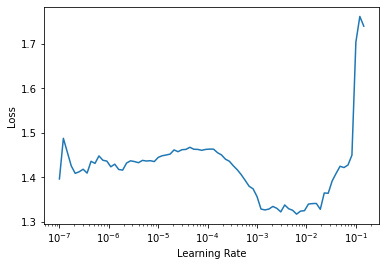

In [24]:
lr_min, _ = learn.lr_find(suggestions=True)
lr_min

Der LR Finder schlägt eine LR von 6E-4 vor. Betrachtet man diesen Punkt auf dem Plot, erkennt man, dass diese LR gut geeignet ist, da der Lossverlauf hier abfallend ist.

Anschließend kann das Training über die `fit_one_cycle` Methode gestartet werden. \
Hierfür wird zunächst nur der oberste Layer des Modells trainiert, da die anderen eingefroren wurden.

In [25]:
learn.fit_one_cycle(1,lr_max=lr_min)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.703116,0.668231,0.731153,0.439204,0.555189,0.455301,02:41


Nach nur einer Epoch erreicht das Modell bereits eine Accuracy von 73,11 %.

Über das `Learner` Objekt kann man sich anschließend ein paar Beispiel Vorhersagen anzeigen lassen:

In [26]:
learn.show_results(learner=learn)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,text,category,target
0,@ CoYoSilver @ Grace30714933 @ RalfTHeuer @ Venum27004632 @ chris _ 98763 @ ph _ phanuel @ ChisNoria @ assassina36 @ wellejena @ Bibby182 @ bine1007 @ Iamcovar @ AufgewachteWelt @ EngelGert @ Lukas64F @ Ron1872 @ Ungebeten1 @ PTroll3 @ _ Apuleius @ LouisPeterle @ machata9 @ Ich _ hake _ nach @ n59 _ puppche @ KoyamaMichi @ Cherylli18 @ BoteDesUnrechts @ ASiegwart @ freitweeter @ _ Migraene _ @ OdmantSuperstar @ Lanyihunter1 @ smuelle26677552 @ MaXanonymous @ Johannes135 @ FredKrger2 @ Connybub @ heidi1274 @ pseudros @ Strandvogt3 @ MadameSchwarzi @ Hausfrau4ever @ Robert19594 @ Invictu53409591 @ Vigilant _ _ A @ estathor @ Metalwilli @ willplaat @ 2018Wahrheit @ Kabra66 Vielleicht die Relativierung des Abtötens deutscher Jugendlicher durch vor die Gleise schubsen. | LBR | Durch Scheinflüchtlinge. | LBR | Deutsche Leben sind wertlos gestellt. Wann baumeln die ersten Verantwortlichen endlich an den Laternen?,ABUSE,OTHER
1,@ troll _ putin @ SJW _ MadBunny @ machtjanix23 @ Steffmann45 @ petpanther0 @ mastermikeg @ Norbinator2403 @ ennof _ @ AthinaMala @ NancyPeggyMandy @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ _ macmike @ ellibisathide @ MD _ Franz @ sjw Vielleicht hat sie genauso wie ich die Nase voll von Oberlehrern mit dem von Barnett angestrebten IQ 90.,INSULT,OTHER
2,"@ MotziKlaus @ J _ B _ oo7 @ MiriamOzen @ VonSchwer @ NancyPeggyMandy @ Maggielein _ @ ellibisathide @ Ich _ bin _ ich78 @ ichbinkoelnerin @ lawyerberlin @ NorgePrivacy @ MD _ Franz @ SM100d @ SteinbachErika @ IQ _ Stimulator @ PetrBystronAfD @ FabriziaFalcone @ emrich _ 5933 @ drbrandner @ ibikus31 @ KrahMax Ich frage mich täglich, was man den Leuten ins Essen getan hat, dass sie so dumm und naiv geworden sind....",INSULT,INSULT
3,"@ vivi _ 4234 @ Alfred996 @ der _ provokateur @ AndreasWerwolf @ dr _ ecksack _ Hey, Hey, hey... Sie sollten aufhören auf @ Alfred996 rumzuhacken wenn Sie eigentlich mich meinen! | LBR | Da Sie aber wirklich keinen Draht zu Sarkasmus und schwarzem Humor zu haben scheinen, macht eine weitere Diskussion keinen Sinn. | LBR | Die Tweets in ihrer TL sprechen übrigens für sich! < U + 0001F92E >",OTHER,OTHER


#### Ausprobieren der Vorhersage eigener Beispiele
Sobald man ein trainiertes Modell hat, kann man dieses via `blurr_predict` Vorhersagen treffen lassen. Hierfür muss man wie bei der Hugging Face Transformer Pipeline nur einen String übergeben und erhält als Ergebnis die Vorhersage des Modells zurück.

In [27]:
learn.blurr_predict('Du bist eine dumme Sau!')

[(('INSULT',),
  (#1) [tensor(1)],
  (#1) [tensor([0.1619, 0.6806, 0.0860, 0.0714])])]

In [28]:
learn.blurr_predict("Mensch ist das ein schönes Wetter draußen @CarstenBartelt")

[(('OTHER',),
  (#1) [tensor(2)],
  (#1) [tensor([0.0082, 0.0110, 0.9746, 0.0061])])]

#### Trainieren der tieferen Layer
Um auch die tieferen Layer des Modells trainieren zu können, muss es zunächst unfreezed werden:

In [29]:
learn.unfreeze()

Anschließend kann man wieder den Learning Rate Finder nutzen, um den LR Parameter einzustellen:

6.309573450380412e-08

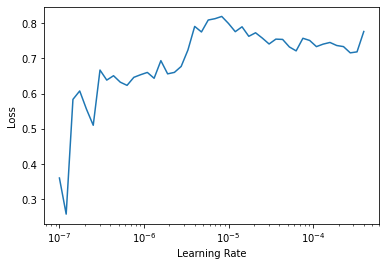

In [30]:
lr_min, _ = learn.lr_find()
lr_min

Obwohl der der LR Finder eine LR von 6E-8 vorschlägt lässt sich am gedruckten  Lossverlauf erkennen, dass der Vorschlag wahscheinlich nicht die besten Ergebnisse liefern wird. Daher wird das Feintuning mit einem Wert von 2E-5 durchgeführt. Dieser Wert wurde gewählt, weil der Lossverlauf in diesem Bereich in einer Abwärtsbewegung ist. Hinzu kommt, dass 2E-5 der empholende Standardwert für das Feintuning von Transformer Modellen darstellt.

In [31]:
learn.fit_one_cycle(4,lr_max=2e-5)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.642181,0.642910,0.744715,0.568028,0.588950,0.573135,04:15
1,0.541668,0.594693,0.774631,0.621041,0.660090,0.630919,04:16
2,0.163605,0.732732,0.777822,0.617657,0.670838,0.640968,04:18
3,0.045507,0.909257,0.776625,0.610574,0.666786,0.634867,04:18


Der eingebaute Recorder ermöglicht es, den Verlauf der Loss über das Training zu plotten.

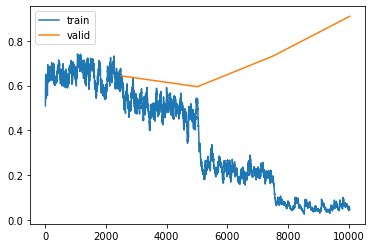

In [33]:
learn.recorder.plot_loss()

Der Plott lässt erkennen, dass nach circa der halben Trainingszeit der Loss für das Validierungsset stark zunimmt. Somit wurde der Optimalpunkt überschritten und das Modell beginnt zu overfitten bzw. scheint die LR für weitere Epochs zu groß zu sein.

#### Evaluation des Modells mit dem Testset
Das Modell kann anschließend über die `validate` Methode evaluiert werden. Dafür wird der DataLoader des Testdatensatz übergeben. Als Ausgabe erhält man die berechneten Metriken zurück:

In [34]:
learn.validate(dl=dls_test.valid)

(#5) [1.1226829290390015,0.7561860680580139,0.5188353582840483,0.5962666538360677,0.5474517217933418]

#### Trainieren eines weiteren Modells
Um zu testen, ob ein Feintuning mit nur 2 Epochs etwas bessere Ergebnisse erzielen kann, wird ein weiteres Modell trainiert.

In [36]:
# Erzeugen einer neuen Modellinstanz
_, _, _, hf_model2 = BLURR_MODEL_HELPER.get_hf_objects(model_checkpoint, task=hf_task,config_kwargs={'num_labels': num_labels})

model2 = HF_BaseModelWrapper(hf_model2)

learn2 = Learner(dls, 
                model2,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,Recall(average='macro'),Precision(average="macro"),F1Score(average="macro")],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

Hierfür wird nach der Erstellung des Learner zunächst der Klassifizierungskopf wie im vorherigen Modell trainiert.

In [37]:
learn2.create_opt()
learn2.freeze()
# Training des Klassifizierungskopfs
learn2.fit_one_cycle(1,lr_max=6e-4)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.617425,0.670071,0.733147,0.427553,0.603617,0.447280,02:39


Anschließend wird das gesamte Modell unfreezed und mit einer LR von 2E-5 für nur zwei statt vier Epochs trainiert:

In [38]:
learn2.unfreeze()
# Training des gesamten Modells
learn2.fit_one_cycle(2,lr_max=2e-5)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.575462,0.815375,0.725568,0.397936,0.679134,0.435150,04:12
1,0.365300,0.610830,0.778221,0.605897,0.673139,0.634074,04:13


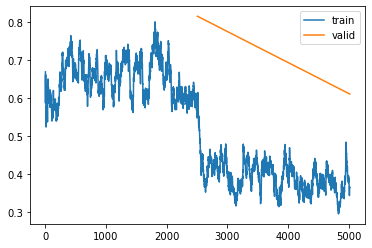

In [39]:
learn2.recorder.plot_loss()

Der Plot lässt erkennen, dass nun kein Overfitting des Modells stattfindet. Die fallende Validationlosskurve deutet nun auf ein Underfitting hin. Vergleicht man jedoch diesen Plot mit dem vorherigen, dann ist zu erkennen, dass beim vorherigen Modell ein sprunghafter Wechsel von Underfitting zu Overfitting auftrat. Dieser Sprung wurde im aktuellen Modell verhindert.

In [40]:
learn2.validate(dl=dls_test.valid)

(#5) [0.7195938229560852,0.761134922504425,0.5219965804489308,0.6108226082784268,0.5547417043267424]

Gegenüber dem ersten Modell konnte Dank Verhinderung des Overfittings eine leicht bessere Modellperformance erreicht werden.

#### Trainieren eines Modells mit mehr Schritten beim Gradual Unfreezing
In diesem Abschnitt soll getestet werden, ob mit weiteren Unfreezing Schritten eine bessere Modellperformance erreicht werden kann.

In [48]:
# Erzeugen einer neuen Modellinstanz
_, _, _, hf_model3 = BLURR_MODEL_HELPER.get_hf_objects(model_checkpoint, task=hf_task,config_kwargs={'num_labels': num_labels})

model3 = HF_BaseModelWrapper(hf_model3)

learn3 = Learner(dls, 
                model3,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,Recall(average='macro'),Precision(average="macro"),F1Score(average="macro")],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

Nachdem der Learner erzeugt wurde und alle Layer eingefroren wurden, kann auch hier die LR gesucht werden.

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=0.03981071710586548)

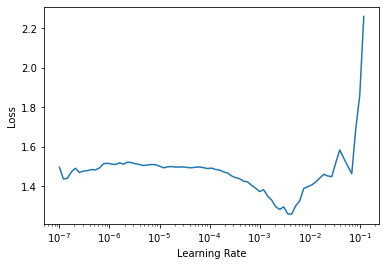

In [51]:
learn3.create_opt()
learn3.freeze()
learn3.lr_find()

Der LR-Finder schlägt eine LR von 4E-4 vor. Anhand des Plots kann bestätigt werden, dass diese LR geeignet ist. Der finale Layer des Modells wird anschließend mit dieser LR trainiert.

In [52]:
learn3.fit_one_cycle(1,4e-4)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.691003,0.689094,0.726366,0.409484,0.470626,0.424576,02:38


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Anschließend kann das Modell mit der Methode freeze_to() stufenweise unfreezed werden, um immer mehr Parametergruppen zusammen zutrainieren (Gradual Unfreezing):

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=6.309573450380412e-07)

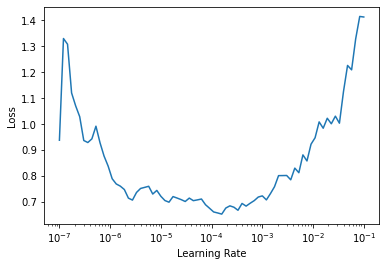

In [55]:
learn3.freeze_to(-2)
learn3.lr_find()

Die Verwendung der `slice`-Syntax erlaubt es den ersten Wert für die ersten Layer des Modells zu verwenden und den zweiten für den finalen Layer. Die Layer dazwischen erhalten gleichverteilte LR zwischen den beiden Parameterwerten. \
Das der erste Wert durch 2.6**4 geteilt wird, ist eine Empfehlung aus dem Buch "Deep Learning for Coders with fastai and PyTorch" S.349

In [56]:
learn3.fit_one_cycle(1,slice(1e-6/2.6**4,1e-6))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.729285,0.691568,0.724771,0.403337,0.470274,0.419088,02:41


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Anschließend wird erneut ein weiterer Layer des Modelles entfroren und die LR bestimmt:

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=1.0964781722577754e-06)

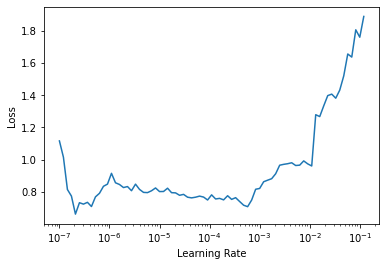

In [58]:
learn3.freeze_to(-3)
learn3.lr_find()

In [59]:
learn3.fit_one_cycle(1,slice(5e-5/2.6**4,5e-5))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.566753,0.631629,0.745911,0.496375,0.658846,0.540361,04:10


Da es keine weiteren Parametergruppen mehr gibt kann nun das gesamte Modell unfreezed werden. Anschließend wird wieder die LR bestimmt und das Modell für weitere Epochs 3 trainiert.

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=6.309573450380412e-07)

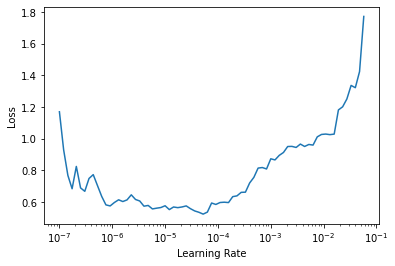

In [69]:
learn3.unfreeze()
learn3.lr_find()

In [70]:
learn3.fit_one_cycle(3,slice(2e-5/2.6**4,2e-5))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.559639,0.618731,0.753889,0.541236,0.654547,0.572459,04:12
1,0.541269,0.616181,0.759075,0.538773,0.658824,0.575444,04:12
2,0.452493,0.617594,0.761468,0.546605,0.670947,0.586447,04:11


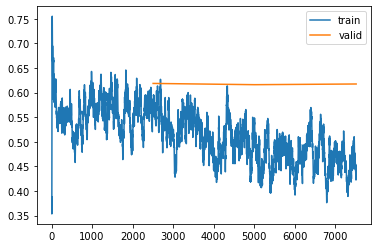

In [71]:
learn3.recorder.plot_loss()

Der Plot weist keine Anzeichen für ein Overfitting des Modells auf.

In [72]:
learn3.validate(dl=dls_test.valid)

(#5) [0.6989423632621765,0.7522270083427429,0.4486248332522093,0.5323360570754752,0.46103251354160096]

Die Validierung gegen das Testset zeigt eine deutlichen Leistungsabfall gegenüber dem Modell, welches in nur 2 Unfreezing Schritten trainiert wurde. Da ebenfalls noch kein Overfitting zu erkennen ist, wird durch weiteres Finetuning versucht die Modellleistung zu erhöhen:

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=9.12010818865383e-07)

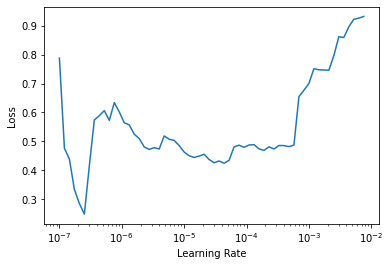

In [75]:
learn3.lr_find()

In [76]:
learn3.fit_one_cycle(2,slice(4e-6/2.6**4,4e-6))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.469179,0.623198,0.760670,0.539435,0.674255,0.580813,04:13
1,0.352114,0.622354,0.761867,0.543371,0.676074,0.584053,04:13


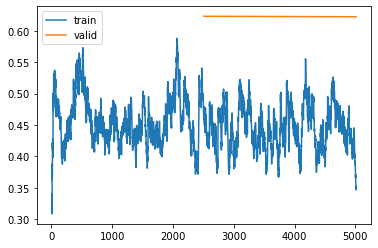

In [77]:
learn3.recorder.plot_loss()

In [78]:
learn3.validate(dl=dls_test.valid)

(#5) [0.7103607058525085,0.7505773901939392,0.44428841151709125,0.5294625241197878,0.4564212321682876]

Es konnte durch die Anwendung der Best Practice Methoden aus dem UMLFit-Ansatz keine Verbesserung der Modellleistung erreicht werden. In diesem Anwendungsbeispiel verschlechterte sich die Modellleistung sogar signifikant. Das weitere Feintuning brachte auch keine Verbesserung der Modellleistung mit sich.

#### Speichern des Models

In [34]:
learn.export(fname=f'./deepset_finetuned/offensive_language_deepset_{task}_standard_finetune_gem_germeval2019_split_makrof1_fastai.pkl')

#### Anwendung des gespeicherten Modells
Um das gespeicherte Modell anzuwenden, muss dieses zunächst geladen werden: 

In [35]:
saved_model = load_learner(fname=f'./deepset_finetuned/offensive_language_deepset_{task}_standard_finetune_gem_germeval2019_split_makrof1_fastai.pkl')

Anschließend kann die `blurr_predict` Methode genutzt werden, um Vorhersagen zu generieren:

In [36]:
saved_model.blurr_predict("Man bist du ein Assi @BertholdBrecht")

[(('INSULT',),
  (#1) [tensor(1)],
  (#1) [tensor([0.0886, 0.5450, 0.3212, 0.0453])])]

In [37]:
saved_model.blurr_predict('''“Der Sozialismus ist eine Religion der Lüge. Ihre Glaubenssätze sind:
                            Neid und Missgunst, Hass und Verachtung, Faulheit und Mittelmäßigkeit, 
                            Raub und Diebstahl.” ― Roland Baader"''')

[(('OTHER',),
  (#1) [tensor(2)],
  (#1) [tensor([0.1765, 0.0669, 0.7548, 0.0018])])]

In [38]:
saved_model.blurr_predict('So was unfreundliches kann ja nur von einem Türken kommen @Ügütz')

[(('OTHER',),
  (#1) [tensor(2)],
  (#1) [tensor([0.3470, 0.2091, 0.4327, 0.0112])])]

In [39]:
saved_model.blurr_predict('@Robinhood Dieser Scheiss der da gestern passiert ist, geht ja mal gar nicht ')

[(('INSULT',),
  (#1) [tensor(1)],
  (#1) [tensor([0.1279, 0.3910, 0.2458, 0.2354])])]